### Pemodelan pergerakan harga saham Netflix dengan Deep Learning untuk prediksi
> Periode data yang diambil:  01 Januari 2015 - 07 Desember 2020
>
>Yang digunakan 800 observasi terakhir: 680 untuk training, 120 untuk testing
>
>https://finance.yahoo.com/quote/NFLX?p=NFLX


In [1]:
from numpy import *   
import numpy as np
from numpy.random import *
import pandas as pd
import scipy.stats
import statsmodels.api as sm
from tabulate import tabulate
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
%matplotlib inline

set_printoptions(precision = 3, suppress = True, formatter = {'float':'{:7.4f}'.format})

acf  = lambda y, lag: [corrcoef([y[:-t], y[t:]])[0,1] for t in arange(1, lag)]

def steps(x, step):
    obs  = len(x)-step
    xt   = x[:obs,:]
    for i in arange(1,step+1):
        xt = hstack((xt, x[i:obs+i,:]))
    return xt

In [2]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller Test:
        adfTest = adfuller(timeseries, autolag='AIC')
        self.pValue = adfTest[1]
        if (self.pValue < self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            
            #add critical value
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key]=value
                
            print('Dickey-Fuller Test Results')
            print(dfResults)

                 0
count  1493.000000
mean    239.171179
std     134.424210
min      45.547142
25%     109.730003
50%     198.369995
75%     351.339996
max     556.549988


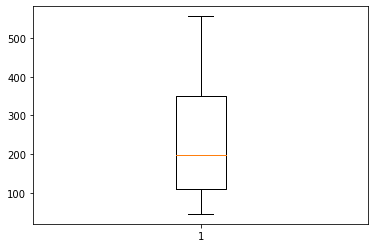

Dickey-Fuller Test Results
ADF Test Statistic        -0.182388
P-Value                    0.940589
# Lags Used               22.000000
# Observations Used     1470.000000
Critical Value (1%)       -3.434806
Critical Value (5%)       -2.863508
Critical Value (10%)      -2.567818
dtype: float64
Apakah data stasioner? False



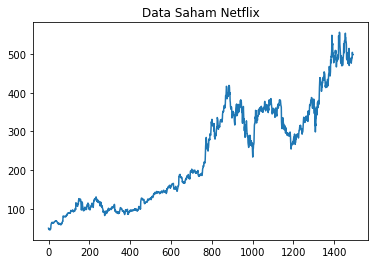

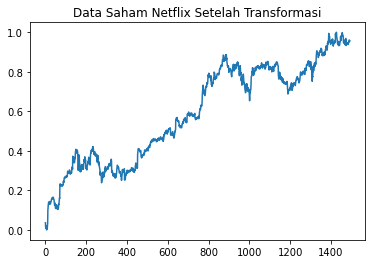

Autocorrelation function:
 [ 0.9991  0.9983  0.9973  0.9964  0.9954  0.9945  0.9936  0.9928  0.9920
  0.9913  0.9905  0.9898  0.9891  0.9884  0.9877  0.9870  0.9863  0.9855
  0.9847  0.9838  0.9831  0.9822  0.9815  0.9809]


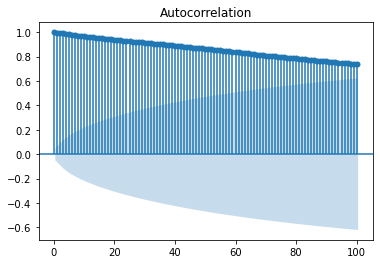

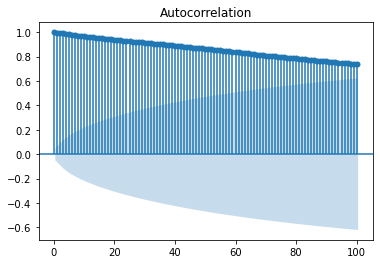

In [3]:
A = pd.read_excel('D:/Python Code/Ekonometrika/NFLX.xlsx').values  #Data time series harian harga saham Intel sejak 02 Januari 2015
B = (log(A[:,4:5].astype(float)))  #Kolom kelima isinya close price, 
                                   #dtype harus float dan list agar bisa dihitung acf-nya               

df = pd.DataFrame(A[:,4:5].astype(float))
print(df.describe(include='all'))
plt.boxplot(A[:,4:5].astype(float))
plt.show()

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(A[:,4:5].astype(float),printResults = True)
print("Apakah data stasioner? {0}\n".format(sTest.isStationary))
    
Bmin = min(B)
Bmax = max(B)
b = (B-Bmin)/(Bmax-Bmin)
ACF = array(acf(b.squeeze(),25))

ts = 1   #Di literatur Time Series digunakan istilah 'lag' sebagai padanan istilah 'timestep' ini
xt = steps(b, ts)  #Dihasilkan matriks dengan 2 (= ts+1) kolom, kolom pertama menjadi variabel X
                   #dan kolom terkhir menjadi variabel y
x = xt[:,:-1]      #menghilangkan vektor terakhir, jadinya hanya satu kolom (vektor kolom)
x = hstack((ones([len(xt),1]), x))   #Ditambahkan vektor satuan, jadinya ada dua kolom (matriks)

#Data untuk training
X = x[690:1370, :]     #Ambil observasi agar diperoleh untuk varibel X sebanyak 620
y = xt[690:1370, -1:]  #Ambila kolom terakhir xt untuk dijadikan sebagai variabel y

#Data untuk testing
Xtest = x[1370:,:]      #ambil jumlah observasi sebanyak 120
ytest = xt[1370:, -1:]  #ambil kolom terakhir

plt.plot(A[:,4:5])
plt.title('Data Saham Netflix')
plt.show()

plt.plot(b)
plt.title('Data Saham Netflix Setelah Transformasi')
plt.show()

print('Autocorrelation function:\n', ACF)
sm.graphics.tsa.plot_acf(b,lags=100)

In [4]:
A[0:1]   #Observasi pertama dari data aslinya

array([[Timestamp('2015-01-02 00:00:00'), 49.151428, 50.331429, 48.73143,
        49.848572, 49.848572, 13475000]], dtype=object)

Sampai epoch ke 12000 dicapai akurasi MSE sebesar 0.0114605 dengan waktu 0:00:02.360185
MSE training: 0.0114605 
MSE testing : 0.0006367
Sampai epoch ke 24000 dicapai akurasi MSE sebesar 0.0586224 dengan waktu 0:00:04.697929
MSE training: 0.0586224 
MSE testing : 0.0026406
Sampai epoch ke 36000 dicapai akurasi MSE sebesar 0.0003277 dengan waktu 0:00:06.961874
MSE training: 0.0003277 
MSE testing : 0.0019788
Sampai epoch ke 48000 dicapai akurasi MSE sebesar 0.0001450 dengan waktu 0:00:09.296628
MSE training: 0.0001450 
MSE testing : 0.0001290
Sampai epoch ke 60000 dicapai akurasi MSE sebesar 0.0001341 dengan waktu 0:00:11.595476
MSE training: 0.0001341 
MSE testing : 0.0001297

Akurasi dengan data training: 0.0001341 



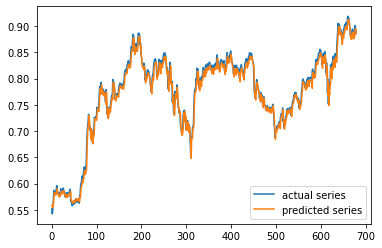

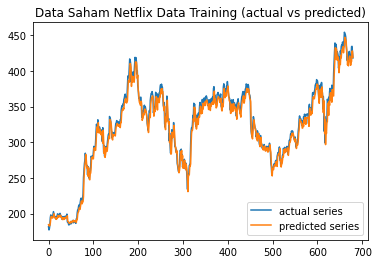

In [28]:
#Note best result: alpha = 3.5, H1 = 4, H2 = 4, ts =1;  
alpha = 5  #learning rate   
H1    = 5    #jumlah neurons di hidden layer ke 1  
H2    = 5    #jumlah neurons di hidden layer ke 2 

seed(20201202)
epochs = 60000  #proses belajar sebanyak epochs kali putaran
epoch  = 5       #akan ditampilkan hasil kemajuan belajar sebanyak 5 kali (boleh diganti-ganti)

[N, K] = shape(X)   #Ukuran matriks X
w0 = randn(K,H1)    #initial values untuk parameter w0 berupa normal(0,1,[K,H1])
w1 = randn(H1,H2)   #initial values untuk parameter w1 berupa normal(0,1,[H1,H2])
w2 = randn(H2,1)    #initial values untuk parameter w2 berupa normal(0,1,[H2,1])

a = w0
e = w1
c = w2

tic = datetime.now()

yhat = zeros([len(y),epoch])  #Output akan disimpan sebanyak 5 (=epoch) kali
Cost = zeros([epoch])   #Cost function akan disimpan tiap beberapa saat 
i    = 0
for j in range(epochs):
    
    #forward propagation (perambatan maju)
   
    #Layer ke 1
    Z1 = X@w0             #reaksi kimia di layer ke 1
    A1 = 1/(1+exp(-Z1))   #arus listrik di layer ke 1 (output di layer ke 1)
    
    #Layer ke 2
    Z2 = A1@w1            #reaksi kimia di layer ke 2
    A2 = 1/(1+exp(-Z2))   #arus listrik di layer ke 2 (output di layer ke 2)
    
    
    #Layer ke 3 (output layer)
    Z3 = A2@w2   #reaksi kimia di layer ke 3
    A3 = 1/(1+exp(-Z3))   #Ini prediksi harga saham atau yhat (output di layer ke 3)
    
    
    #Backward propagation (perambatan mundur)
    
    #Layer 3
    e      = (y-A3)/sqrt(len(y))
    C      = e.T@e
    delta3 = -e*A3*(1-A3)
    dw2    = A2.T@delta3
    
    #Layer 2
    delta2 = delta3@w2.T*A2*(1-A2)
    dw1    = A1.T@delta2
    
    #Layer 1
    delta1 = delta2@w1.T*A1*(1-A1)
    dw0    = X.T@delta1
    
    #Parameters updating (ini jangan dilakukan sebelum selesai dihitung seluruh deltas)
    #Disinilah dilakukan rekaman pertambahan ilmu pengetahuan (knowledge) selama proses belajar
    
    w2 -= alpha*dw2   #Parameter w2 di-update 
    w1 -= alpha*dw1   #Parameter w1 di-update 
    w0 -= alpha*dw0   #Parameter w0 di-update 
    
    if (j+1)%((epochs)/epoch) == 0:
        yhat[:,i] = A3.squeeze()   #prediksi model disimpan 5 (=epoch) kali saja bila diperlukan untuk di-plot
        Cost[i] = C
        print("Sampai epoch ke", j+1,"dicapai akurasi MSE sebesar %8.7f" %C,"dengan waktu", datetime.now()-tic)
        #Layer ke 1
        Z1 = Xtest@w0
        A1 = 1/(1+exp(-Z1))
        #Layer ke 2
        Z2 = A1@w1
        A2 = 1/(1+exp(-Z2))
        #Layer ke 3
        Z3 = A2@w2
        ytesthat = 1/(1+exp(-Z3))   #Prediksi harga saham
        mse = (y-A3).T@(y-A3)/len(y)   #MSE semasa training
        msetest = (ytest-ytesthat).T@(ytest-ytesthat)/len(ytest)   #MSE semasa testing
        print('MSE training: %8.7f'%mse,'\nMSE testing : %7.7f'%msetest)
        i += 1

toc = datetime.now()
print('\nAkurasi dengan data training: %8.7f' %C,'\n')

ytraino = exp(y*(Bmax-Bmin)+Bmin)         #Kembalikan datanya ke original unit dalam satuan dolar
ytrainhato = exp(A3*(Bmax-Bmin)+Bmin)   #Kembalikan datanya ke original unit dalam satuan dolar

plt.plot(y, label = 'actual series')
plt.plot(yhat[:,epoch-1], label = 'predicted series')
plt.legend()
plt.show()

plt.plot(ytraino, label = 'actual series')
plt.plot(ytrainhato, label = 'predicted series')
plt.title('Data Saham Netflix Data Training (actual vs predicted)')
plt.legend()
plt.show()

In [26]:
w1 = randn(H1,H2)

In [34]:
a,c

(array([[ 9.0381,  6.4737, -2.6568, -0.5922,  0.5735],
        [-14.9154, -6.9864, -0.9698, -2.3882, -4.7163]]),
 array([[ 8.5510],
        [ 2.0820],
        [ 9.3380],
        [ 3.6929],
        [ 0.6976]]))

In [23]:
d

[array([[192.2461, 75.2699, 60.2214, 138.5305, 172.9415],
        [151.1073, 58.5726, 48.8832, 109.7929, 136.2185]]),
 array([[10.5234,  5.6693, 11.4409, 10.1761,  5.3331],
        [20.9808,  9.0685, 19.5544, 21.2078,  7.6026],
        [ 5.4077,  2.2190,  5.2399,  5.0264,  0.9243],
        [10.5841,  1.3027,  7.7921,  7.6239,  3.6734],
        [17.2460,  8.2240, 15.9667, 17.6335,  9.0988]]),
 array([[ 9.9773],
        [ 3.4095],
        [ 8.6144],
        [ 6.8584],
        [11.7820]])]

In [29]:
X = X
Y = y

neu = [5,5,1],['relu','relu','relu']

nh = neu[0]
act_func = neu[1]

seed(20201202)
[N,K] = shape(X)
bobot = []
bias  = []

for i in range(shape(neu)[1]):
    w = randn(K,nh[i])
    K = nh[i]
    bobot.append(w)
    b = randn(nh[i])
    bias.append(b)
    
d = bobot
    
for i in range(epochs):
    
    #layer input ke hidden
    A  = []
    Z1 = X@bobot[0]
    A1 = 1/(1+exp(-Z1))
    A.append(A1)
    m  = 1
    
    #forward
    for j in range(shape(neu)[1]-1):
        Z1 = A[j]@bobot[m]
        A1 = 1/(1+exp(-Z1))
        A.append(A1)
        m = m+1
        
    #layer output ke hidden
    k = 1
    e = (Y-A[-1])/sqrt(len(Y))
    C = e.T@e
    delta = []
    dlt = -e*A[-k]*(1-A[-k])
    dw  = A[-(k+1)].T@dlt
    delta.append(dlt)
    m = 1
    bobot[-1] -= alpha*dw
    
    #backward
    for j in range(shape(neu)[1]-1):
        if j == (shape(neu)[1]-2):
            dlt = dlt@bobot[1].T*A[-(k+1)]*(1-A[-(k+1)])
            dw = X.T@dlt
            k = k+1
            delta.append(dlt)
            bobot[0] -= alpha*dw
        else:
            dlt = dlt@bobot[-m].T*A[-(k+1)]*(1-A[-(k+1)])
            dw = A[-(k+2)].T@dlt
            k = k+1
            delta.append(dlt)
            bobot[-2] -= alpha*dw
    
    if i == (epochs-1):
        print("Sampai epoch ke", i+1,"dicapai akurasi MSE sebesar %8.7f" %C)

Sampai epoch ke 60000 dicapai akurasi MSE sebesar 0.0589570


MSE training: 0.0001341 
MSE testing : 0.0001297


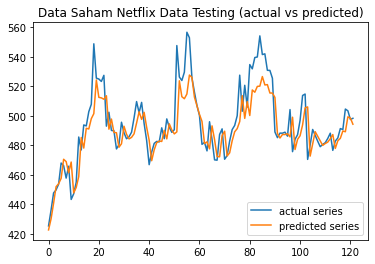

In [6]:
#Parameters w0, w1 dan w2 sebagai ilmu pengetahuan atau knowledge yang diperoleh selama training 
#akan digunakan disini untuk di-test kemampuannya memprediksi. 
#Data yang dipakai Xtest dan ytest yang tidak digunakan selama training.

#Layer ke 1
Z1 = Xtest@w0
A1 = 1/(1+exp(-Z1))

#Layer ke 2
Z2 = A1@w1
A2 = 1/(1+exp(-Z2))

#Layer ke 3
Z3 = A2@w2
ytesthat = 1/(1+exp(-Z3))   #Prediksi harga saham

mse = (y-A3).T@(y-A3)/len(y)   #MSE semasa training
msetest = (ytest-ytesthat).T@(ytest-ytesthat)/len(ytest)   #MSE semasa testing
print('MSE training: %8.7f'%mse,'\nMSE testing : %7.7f'%msetest)

ytesto = exp(ytest*(Bmax-Bmin)+Bmin)         #Kembalikan datanya ke original unit dalam satuan dolar
ytesthato = exp(ytesthat*(Bmax-Bmin)+Bmin)   #Kembalikan datanya ke original unit dalam satuan dolar
plt.plot(ytesto, label = 'actual series')
plt.plot(ytesthato, label = 'predicted series')
plt.title('Data Saham Netflix Data Testing (actual vs predicted)')
plt.legend()
plt.show()

In [7]:
len(y),len(ytest)

(680, 122)

In [8]:
shape(e.T@e)

(1, 1)

In [10]:
shape(A3)

(680, 1)